In [10]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(tidyverse)
    library(ComplexHeatmap)
    library(logger)
    library(nichenetr)
    library(Seurat)
})

In [11]:
sce_hepa <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_hepatocytes_tumor_D20171220.rds")
sce_stromal <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_stromal.rds")
sce_stromal$leiden_sub_anno <- as.character(sce_stromal$leiden_sub_anno)
sce_stromal <- logNormCounts(sce_stromal[, sce_stromal$donor == "D20171220" & sce_stromal$leiden_sub_anno != "8"])

In [12]:
sce_hepa$leiden_sub <- sce_hepa$leiden_sublevel1
sce_hepa$leiden_sublevel1 <- NULL
sce_hepa$leiden_sub_anno <- NULL
sce_stromal$leiden_sub <- sce_stromal$leiden_sub_anno 
sce_stromal$leiden_sub_anno <- NULL

In [13]:
reducedDims(sce_hepa) <- NULL
reducedDims(sce_stromal) <- NULL

In [14]:
sce <- cbind(sce_hepa, sce_stromal)

# Only protein coding

In [15]:
keep <- rowData(sce)$Biotype == "protein_coding"
sce <- sce[keep,]

In [16]:
keep <- calculateAverage(sce) > 1
table(keep)
sce <- sce[keep,]

keep
FALSE  TRUE 
 5664 14150 

# Prepare cellphonedb

In [17]:
#--- Output All cells
mt <- as.matrix(logcounts(sce))
meta <- tibble::tibble(Cell=colnames(mt), 
                       cell_type = colData(sce)[colnames(mt), "leiden_sub"])
meta <- as.data.frame(meta)
rownames(meta) <- meta$Cell

mt <- cbind(Gene = rownames(mt), as.data.frame(mt))
readr::write_tsv(mt, path = paste0("./data/expression_cellphonedb_D20171220_cutoff1.tsv"))
readr::write_tsv(meta, path = paste0("./data/meta_cellphonedb_D20171220_cutoff1.tsv"))


# Analysis CellphoneDB result

In [211]:
sce_hepa <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_hepatocytes_tumor_D20171220.rds")


In [212]:
keep <- rowData(sce_hepa)$Biotype == 'protein_coding'
markers <- findMarkers(sce_hepa, groups = sce_hepa$leiden_sublevel1, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 100),]
})

In [213]:
gene_cellphonedb <- unique(c(top_markers$C03$gene, top_markers$C00$gene))

# Dotplot

In [214]:
sig_means <- read.table("./out/D20171220_tumor2stromal/significant_means.txt", header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)

In [215]:
pvalues_path = "./out/D20171220_tumor2stromal/pvalues.txt"
means_path = "./out/D20171220_tumor2stromal/means.txt"
all_pval = read.table(pvalues_path, header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)
all_means = read.table(means_path, header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)

In [216]:
intr_pairs = all_pval$interacting_pair
all_pval = all_pval[,-c(1:11)]
all_means = all_means[,-c(1:11)]
rownames(all_pval) <- intr_pairs
rownames(all_means) <- intr_pairs

In [217]:
# grep("(Endo|CAF)\\|C[0-9][0-9]", colnames(all_pval), value = T)
selected_columns <- c(grep("C[0][03]\\|(Endo)", colnames(all_pval), value = T))
selected_rows <- apply(all_pval[, selected_columns], 1, function(x) sum(x < 0.05)) != 0
selected_rows <- intr_pairs[selected_rows]
selected_rows <- grep("complex$", selected_rows, value = T, invert = T)

In [218]:
sel_pval = all_pval[selected_rows, selected_columns]
sel_means = all_means[selected_rows, selected_columns]

In [219]:
df_names = expand.grid(selected_rows, selected_columns)
pval = unlist(sel_pval)
pval[pval==0] = 0.0009
plot.data = cbind(df_names,pval)
pr = unlist(as.data.frame(sel_means))
pr[pr==0] = 1
plot.data = cbind(plot.data,log2(pr))
colnames(plot.data) = c('pair', 'clusters', 'pvalue', 'mean')

In [220]:
plot.data$sender <- sapply(strsplit(as.character(plot.data$clusters), "\\|"), `[[`, 1)
plot.data <- plot.data[sapply(strsplit(as.character(plot.data$pair), "\\_"), `[[`, 1) %in% gene_cellphonedb,]

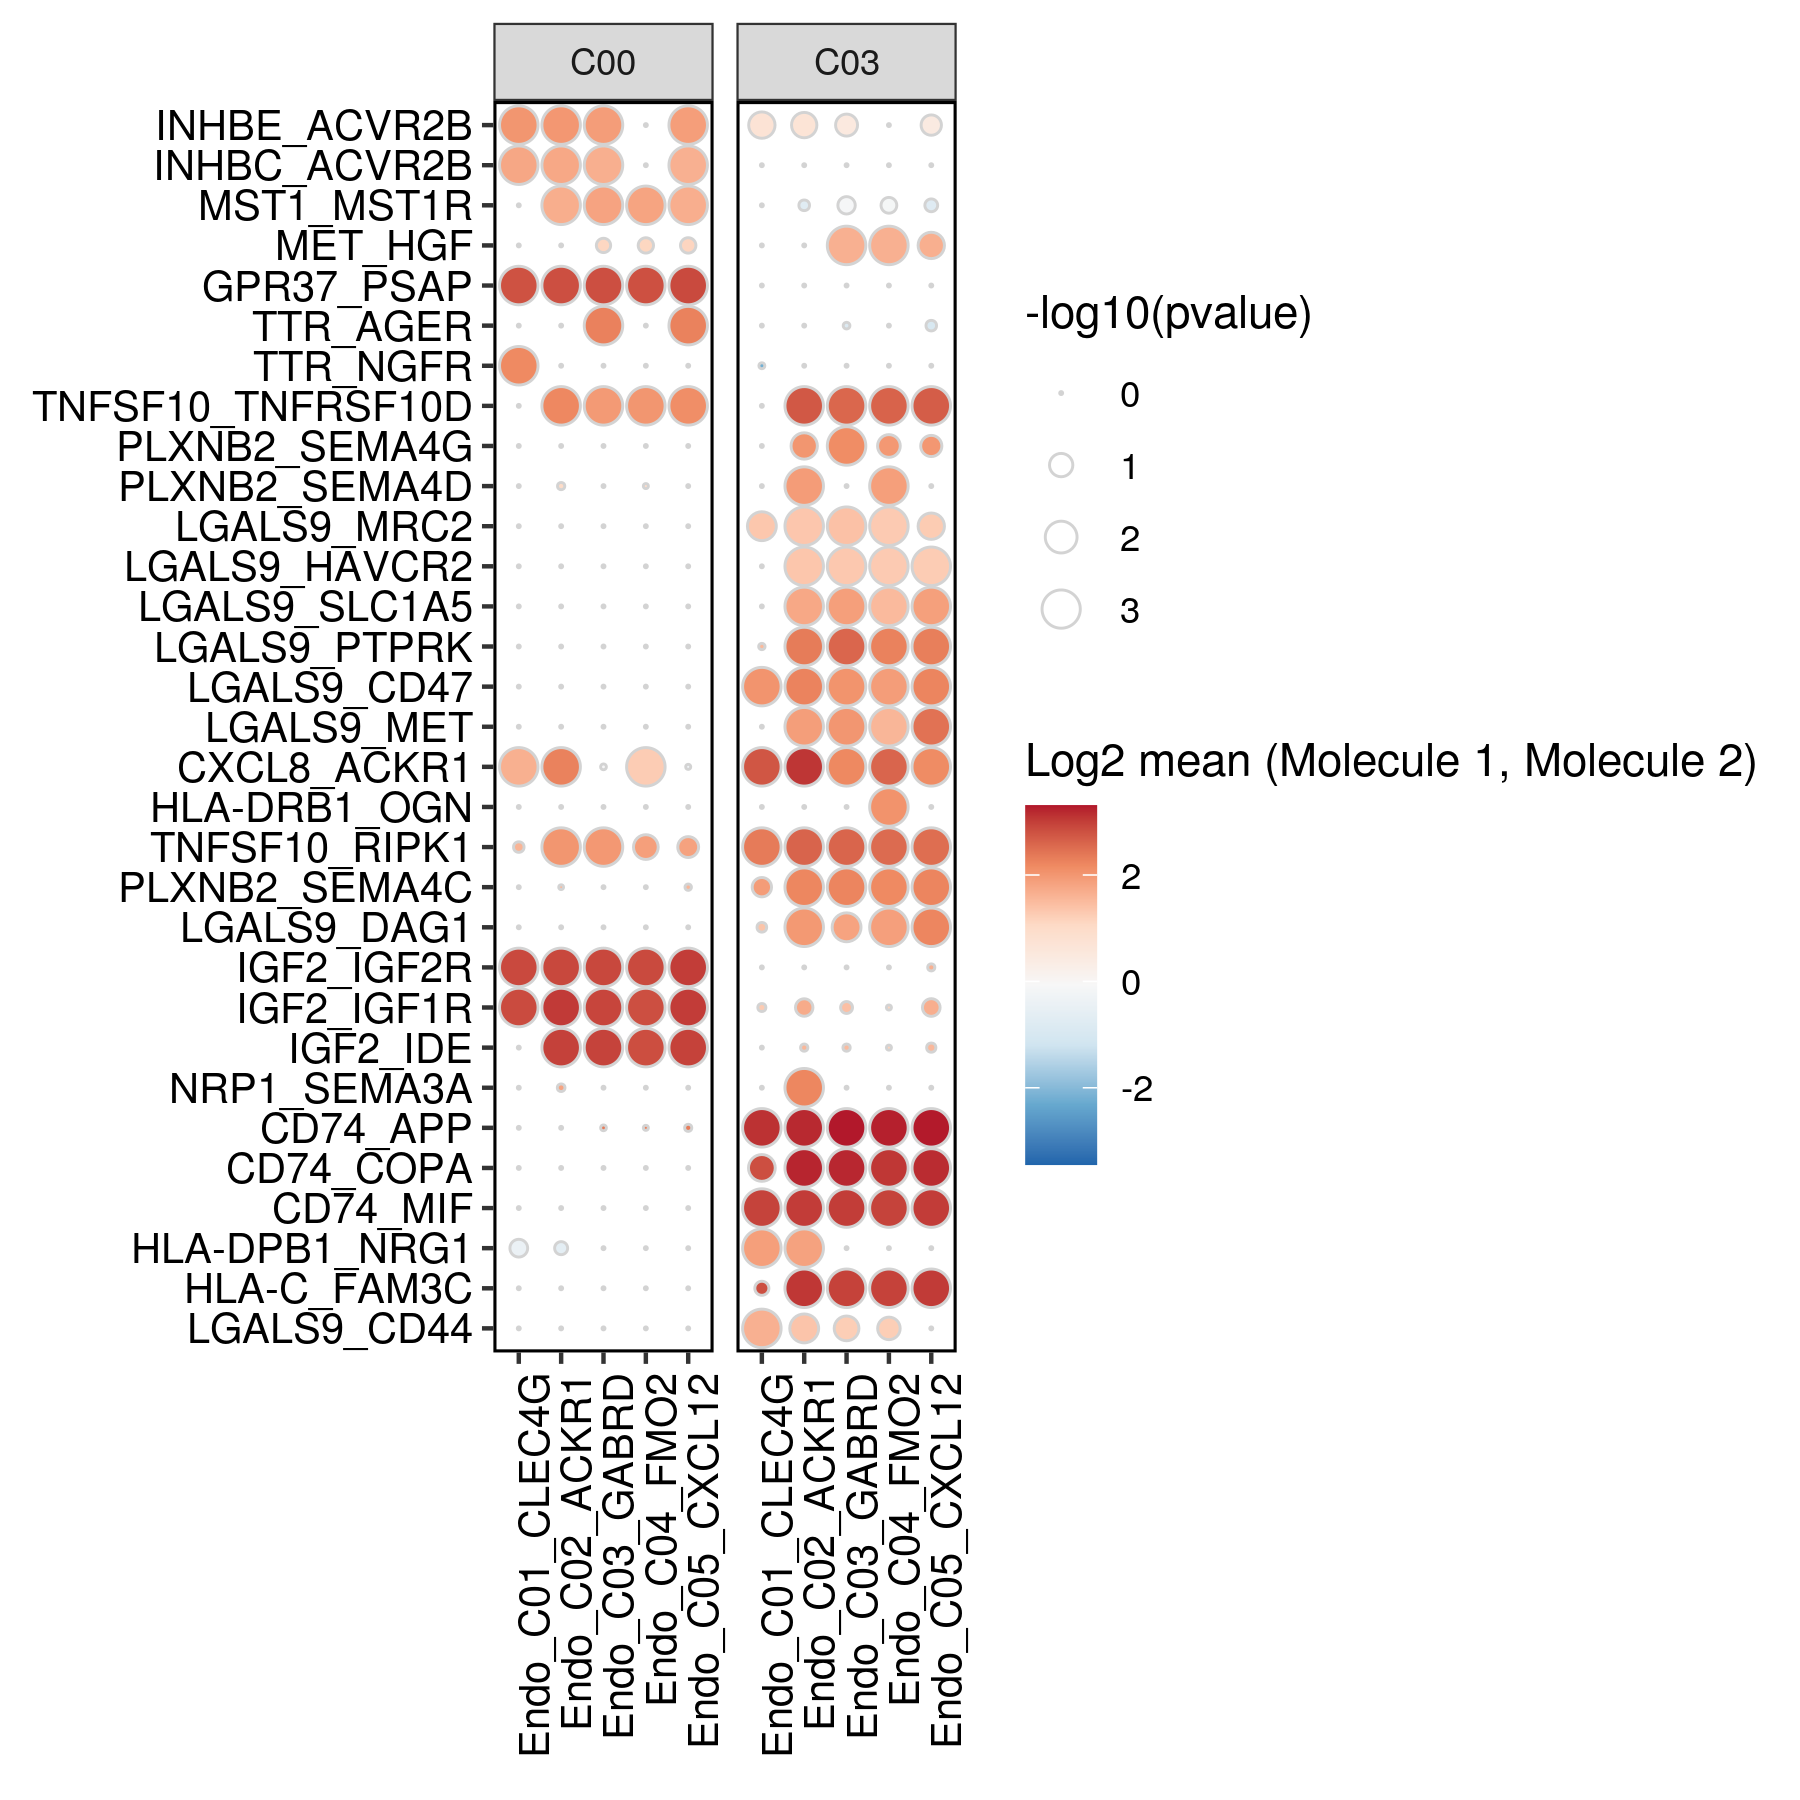

In [221]:
#my_palette <- colorRampPalette(c("black", "blue", "yellow", "red"), alpha=TRUE)(n=399)
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

p <- ggplot(plot.data,aes(x=clusters,y=pair)) +
  geom_point(aes(size=-log10(pvalue),fill=mean),shape = 21, color = 'lightgrey') +
  scale_fill_distiller('Log2 mean (Molecule 1, Molecule 2)', palette  = "RdBu") +
  scale_size(range = c(0, 4)) +
  scale_x_discrete(labels = c("Endo_C01_CLEC4G", "Endo_C02_ACKR1", "Endo_C03_GABRD", "Endo_C04_FMO2", "Endo_C05_CXCL12")) +
  facet_grid(. ~ sender, scales = "free") +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=10, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1),
        axis.text.y = element_text(size=10, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black")) + xlab("Receiver Endothelial Cell")



ggsave(p, filename = "../05_figures/figures/Figure2I_Dotplot_cellphonedb_tumor2endo.pdf", height = 6, width = 6)
p

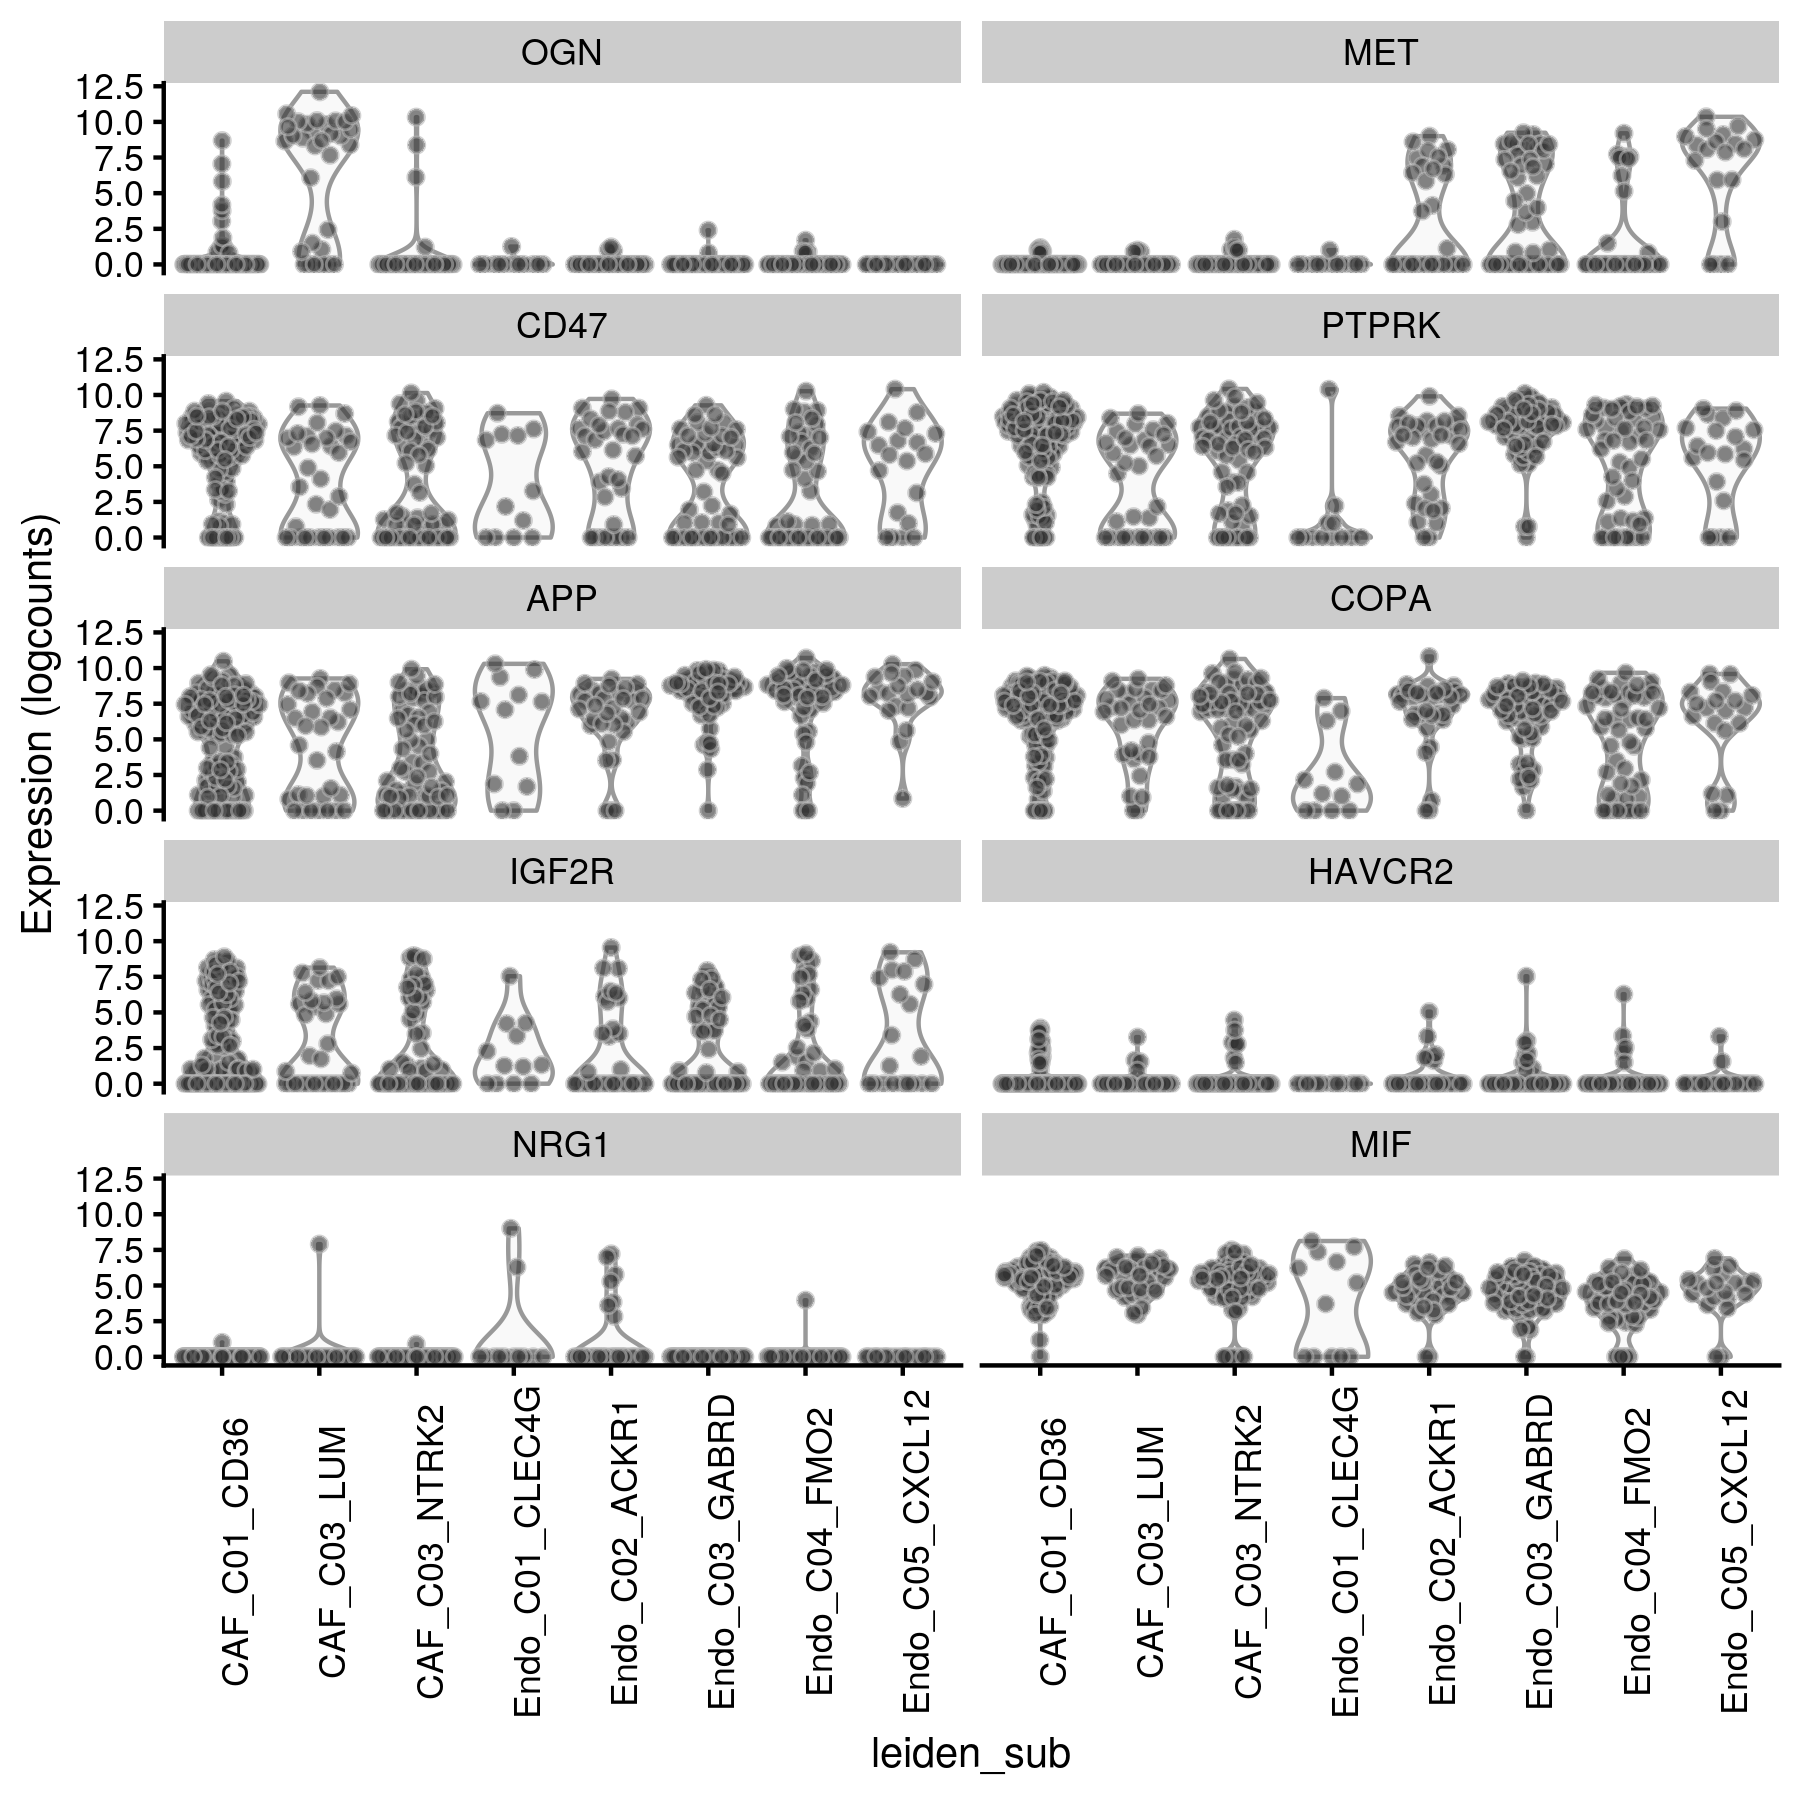

In [222]:
plotExpression(sce_stromal, x = "leiden_sub", features = c("OGN", "MET", "CD47", "PTPRK", "APP", "COPA", "IGF2R", "HAVCR2", "NRG1", "MIF")) + theme(axis.text.x = element_text(angle = 90))

In [223]:
sce_hepa <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_hepatocytes_tumor_D20171220.rds")


In [224]:
keep <- rowData(sce_hepa)$Biotype == 'protein_coding'
markers <- findMarkers(sce_hepa, groups = sce_hepa$leiden_sublevel1, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 50),]
})

In [225]:
gene_cellphonedb <- unique(c(top_markers$C03$gene, top_markers$C00$gene))

# Dotplot

In [226]:
sig_means <- read.table("./out/D20171220_tumor2stromal/significant_means.txt", header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)

In [227]:
pvalues_path = "./out/D20171220_tumor2stromal/pvalues.txt"
means_path = "./out/D20171220_tumor2stromal/means.txt"
all_pval = read.table(pvalues_path, header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)
all_means = read.table(means_path, header=T, stringsAsFactors = F, sep='\t', comment.char = '', check.names=F)

In [228]:
intr_pairs = all_pval$interacting_pair
all_pval = all_pval[,-c(1:11)]
all_means = all_means[,-c(1:11)]
rownames(all_pval) <- intr_pairs
rownames(all_means) <- intr_pairs

In [229]:
# grep("(Endo|CAF)\\|C[0-9][0-9]", colnames(all_pval), value = T)
selected_columns <- c(grep("C[0][03]\\|(CAF)", colnames(all_pval), value = T))
selected_rows <- apply(all_pval[, selected_columns], 1, function(x) sum(x < 0.05)) != 0
selected_rows <- intr_pairs[selected_rows]
selected_rows <- grep("complex$", selected_rows, value = T, invert = T)

In [230]:
sel_pval = all_pval[selected_rows, selected_columns]
sel_means = all_means[selected_rows, selected_columns]

In [231]:
df_names = expand.grid(selected_rows, selected_columns)
pval = unlist(sel_pval)
pval[pval==0] = 0.0009
plot.data = cbind(df_names,pval)
pr = unlist(as.data.frame(sel_means))
pr[pr==0] = 1
plot.data = cbind(plot.data,log2(pr))
colnames(plot.data) = c('pair', 'clusters', 'pvalue', 'mean')

In [232]:
plot.data$sender <- sapply(strsplit(as.character(plot.data$clusters), "\\|"), `[[`, 1)
plot.data <- plot.data[sapply(strsplit(as.character(plot.data$pair), "\\_"), `[[`, 1) %in% gene_cellphonedb,]

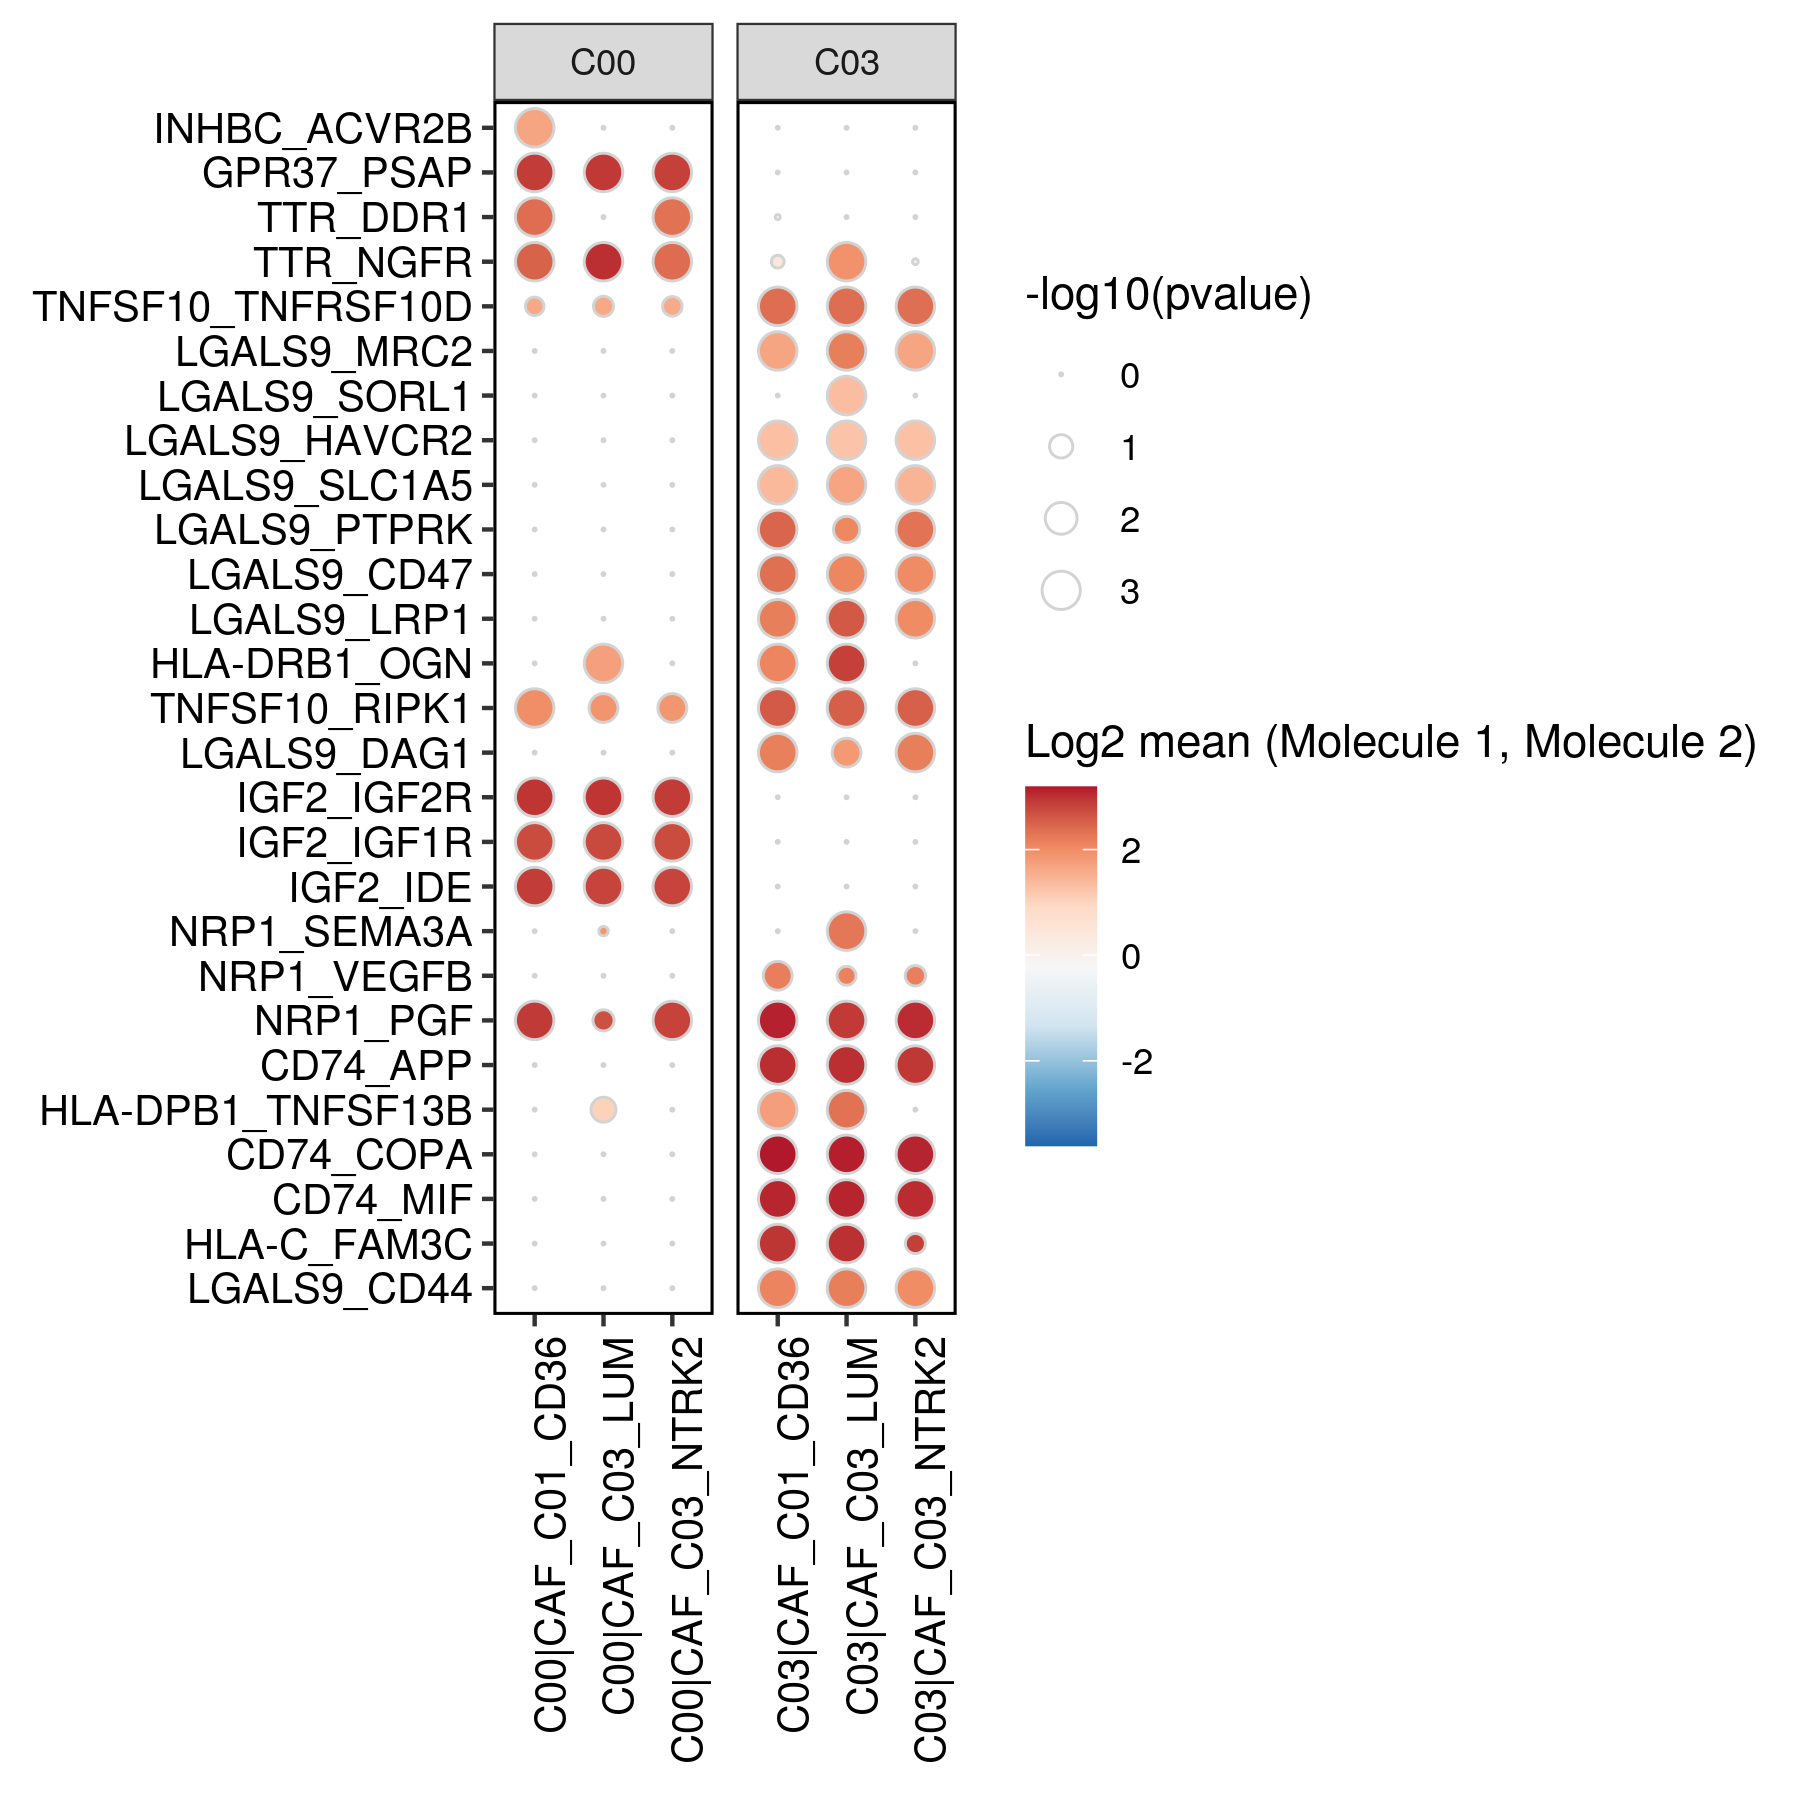

In [233]:
#my_palette <- colorRampPalette(c("black", "blue", "yellow", "red"), alpha=TRUE)(n=399)
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)

p <- ggplot(plot.data,aes(x=clusters,y=pair)) +
  geom_point(aes(size=-log10(pvalue),fill=mean),shape = 21, color = 'lightgrey') +
  scale_fill_distiller('Log2 mean (Molecule 1, Molecule 2)', palette  = "RdBu") +
  scale_size(range = c(0, 4)) +
  #scale_x_discrete(labels = c("Endo_C01_CLEC4G", "Endo_C02_ACKR1", "Endo_C03_GABRD", "Endo_C04_FMO2", "Endo_C05_CXCL12")) +
  facet_grid(. ~ sender, scales = "free") +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=10, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1),
        axis.text.y = element_text(size=10, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black")) + xlab("Receiver CAF Cell")


ggsave(p, filename = "../05_figures/figures/Figure2I_Dotplot_cellphonedb_tumor2caf.pdf", height = 6, width = 6)
p

# Prepare expression data of interacting cells

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [9]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))
weighted_networks = readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds"))

In [15]:

nichenet_output <- nichenet_seuratobj_cluster_de(verbose = T,
  seurat_obj = seuratObj, 
  receiver_reference = "Endo_C01_CLEC4G",, receiver_affected = "Endo_C02_ACKR1", 
  sender = c("C00"), 
  ligand_target_matrix = ligand_target_matrix, lr_network = lr_network, weighted_networks = weighted_networks, organism = "human")

[1] "Read in and process NicheNet's networks"
[1] "Define expressed ligands and receptors in receiver and sender cells"
[1] "Perform DE analysis between two receiver cell clusters"
[1] "Perform NicheNet ligand activity analysis"
[1] "Infer active target genes of the prioritized ligands"
[1] "Infer receptors of the prioritized ligands"


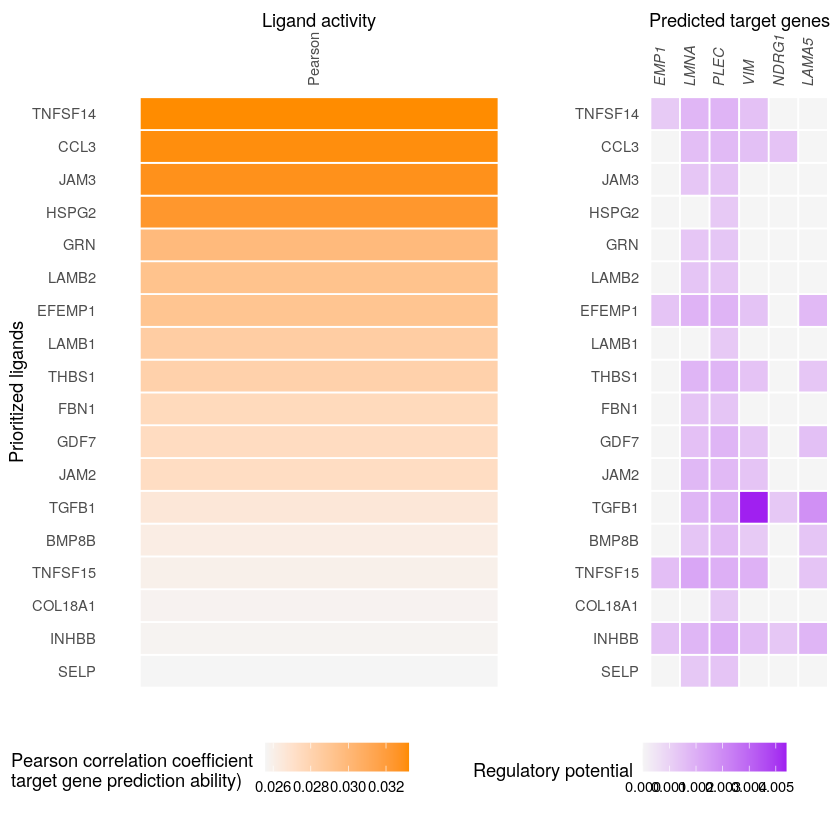

In [16]:
nichenet_output$ligand_activity_target_heatmap

[1] "Read in and process NicheNet's networks"
[1] "Define expressed ligands and receptors in receiver and sender cells"
[1] "Perform DE analysis between two receiver cell clusters"
[1] "Perform NicheNet ligand activity analysis"
[1] "Infer active target genes of the prioritized ligands"
[1] "Infer receptors of the prioritized ligands"


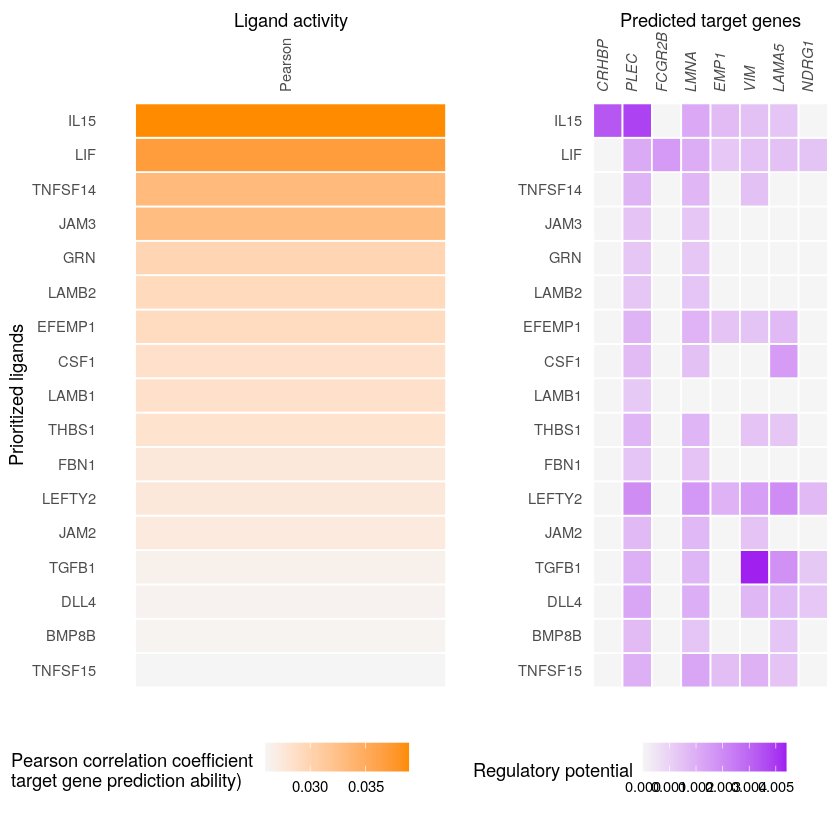

In [20]:
nichenet_output <- nichenet_seuratobj_cluster_de(verbose = T,
  seurat_obj = seuratObj, 
  receiver_reference = "Endo_C01_CLEC4G",, receiver_affected = "Endo_C02_ACKR1", 
  sender = c("C03"), 
  ligand_target_matrix = ligand_target_matrix, lr_network = lr_network, weighted_networks = weighted_networks, organism = "human")
nichenet_output$ligand_activity_target_heatmap

In [19]:
table(sce$leiden_sub)


            C00             C01             C02             C03             C04 
             60              28              25              23              22 
   CAF_C01_CD36     CAF_C03_LUM   CAF_C03_NTRK2 Endo_C01_CLEC4G  Endo_C02_ACKR1 
            133              33              66              12              33 
 Endo_C03_GABRD   Endo_C04_FMO2 Endo_C05_CXCL12 
             54              49              20 

[1] "Read in and process NicheNet's networks"
[1] "Define expressed ligands and receptors in receiver and sender cells"
[1] "Perform DE analysis between two receiver cell clusters"
[1] "Perform NicheNet ligand activity analysis"
[1] "Infer active target genes of the prioritized ligands"
[1] "Infer receptors of the prioritized ligands"


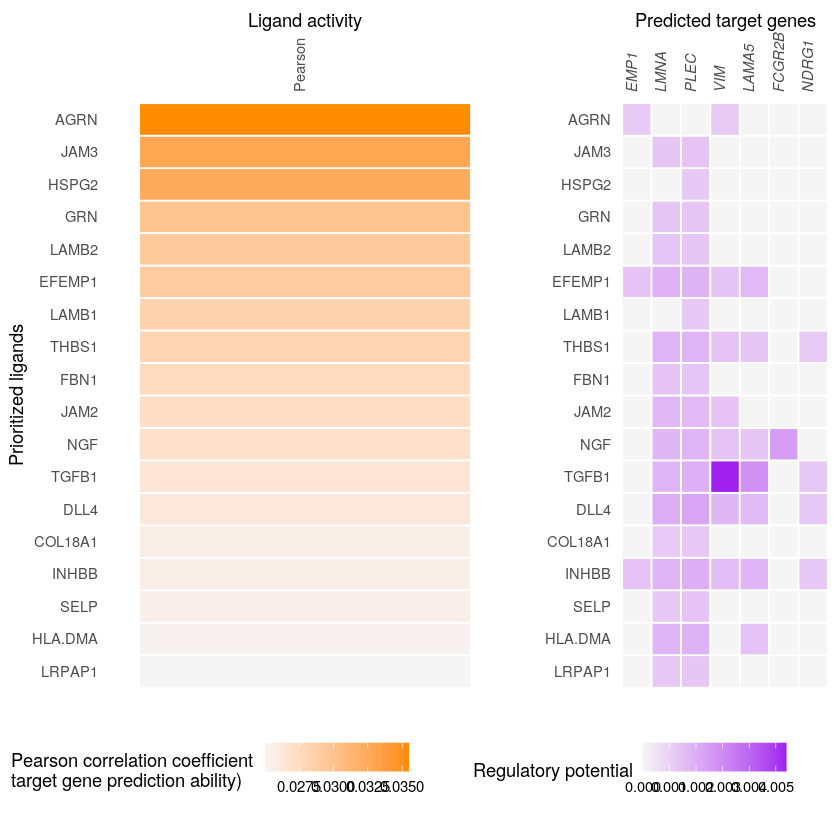

In [18]:
nichenet_output <- nichenet_seuratobj_cluster_de(verbose = T,
  seurat_obj = seuratObj, 
  receiver_reference = "Endo_C01_CLEC4G",, receiver_affected = "Endo_C02_ACKR1", 
  sender = c("C02"), 
  ligand_target_matrix = ligand_target_matrix, lr_network = lr_network, weighted_networks = weighted_networks, organism = "human")
nichenet_output$ligand_activity_target_heatmap

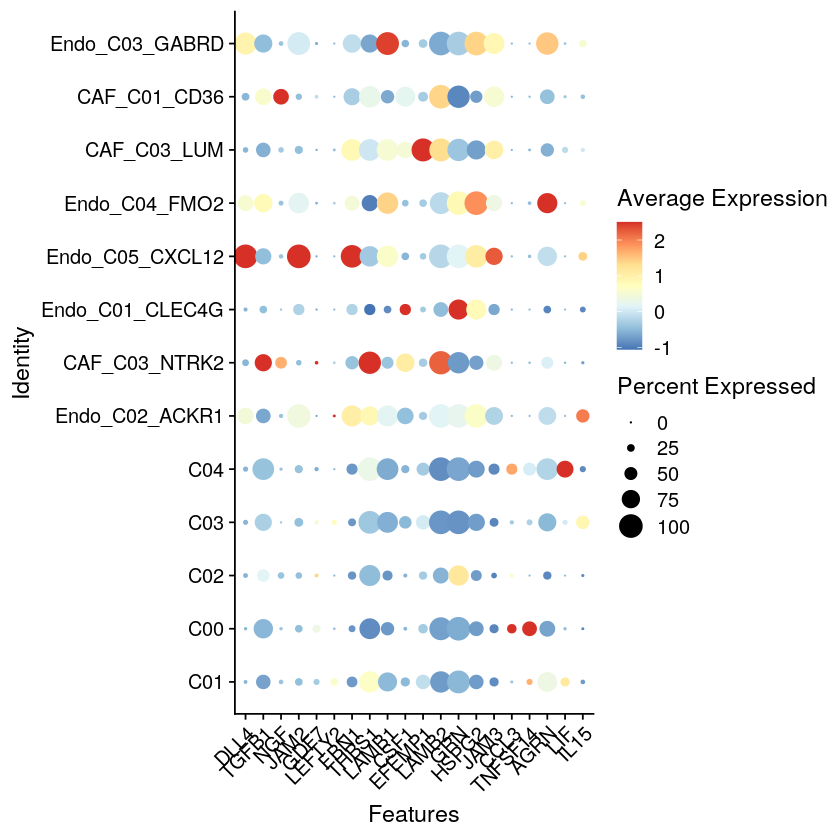

In [13]:
DotPlot(seuratObj, features = nichenet_output$top_ligands %>% rev(), cols = "RdYlBu") + RotatedAxis()